In [1]:
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

Load the Training images

In [3]:
def ignore_masks(path):
    return "mask" not in path.lower()

# Data Preparation for Fruit Multi-Class Classification

In [4]:
fruit_multiclass_train = datasets.ImageFolder(
    root="Project Data/Fruit/Train",
    transform=transforms,
    is_valid_file=ignore_masks
)

fruit_multiclass_val = datasets.ImageFolder(
    root="Project Data/Fruit/Validation",
    transform=transforms,
    is_valid_file=ignore_masks
)

# 4. Create the Loaders
fruit_train_loader = DataLoader(fruit_multiclass_train, batch_size=32, shuffle=True)
fruit_val_loader = DataLoader(fruit_multiclass_val, batch_size=32, shuffle=False)

### Visualize a batch

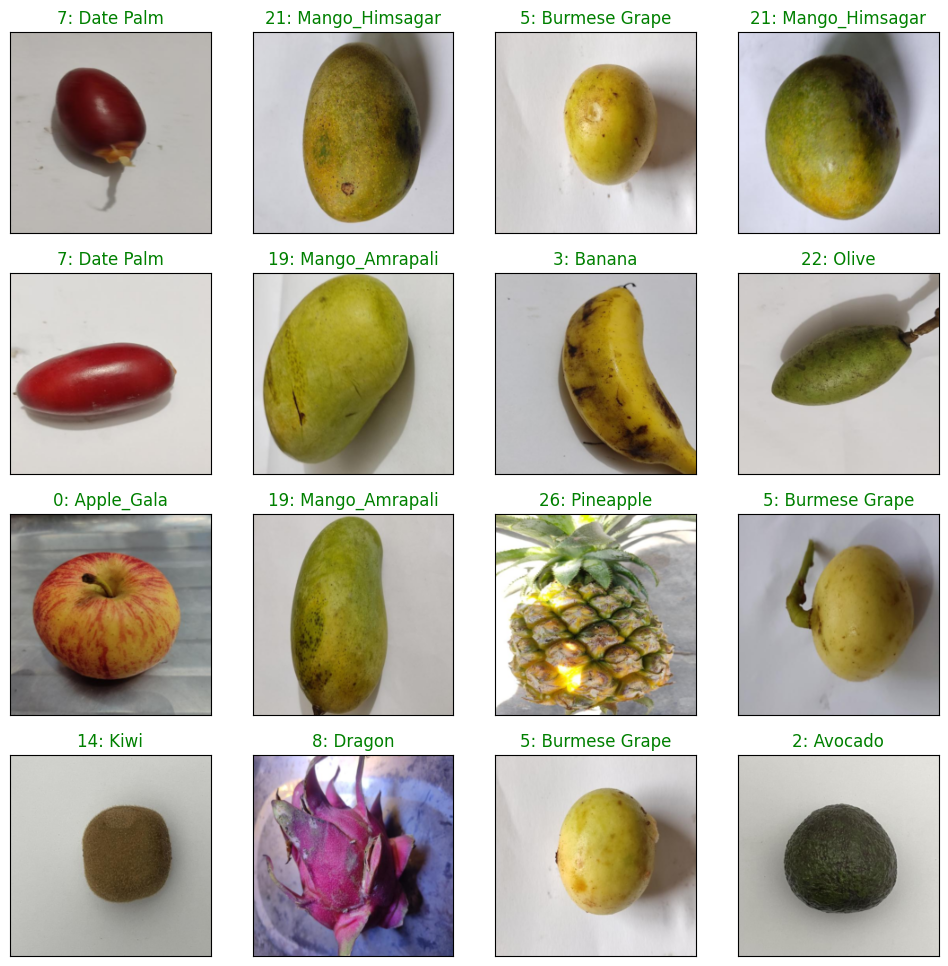

In [5]:
fruit_names = fruit_multiclass_train.classes

data_iter = iter(fruit_train_loader)
images, labels = next(data_iter)

fig = plt.figure(figsize=(12, 12))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    
    img_display = images[i].numpy().transpose((1, 2, 0))
    plt.imshow(img_display)
    idx = labels[i].item()
    real_name = fruit_names[idx]
    
    ax.set_title(f"{idx}: {real_name}", color="green")

plt.show()